In [2]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
import pandas as pdf 

In [3]:
train1 = pd.read_csv('train_month_3_with_target.csv')
train2 = pd.read_csv('train_month_2.csv')
train3 = pd.read_csv('train_month_2.csv')
test1 = pd.read_csv('test_month_1.csv')

In [4]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63697 entries, 0 to 63696
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   client_id                          63697 non-null  object 
 1   homebanking_active                 63697 non-null  int64  
 2   has_homebanking                    63697 non-null  int64  
 3   has_insurance_21                   63697 non-null  int64  
 4   has_insurance_23                   63697 non-null  int64  
 5   has_life_insurance_fixed_cap       63697 non-null  int64  
 6   has_life_insurance_decreasing_cap  63697 non-null  int64  
 7   has_fire_car_other_insurance       63697 non-null  int64  
 8   has_personal_loan                  63697 non-null  int64  
 9   has_mortgage_loan                  63697 non-null  int64  
 10  has_current_account                63697 non-null  int64  
 11  has_pension_saving                 63697 non-null  int

In [16]:
pd.set_option('display.max_columns',None)


In [6]:
train1['customer_since_all'] = pd.to_datetime(train1['customer_since_all'])
train1['customer_since_bank'] = pd.to_datetime(train1['customer_since_bank'])
train1['customer_birth_date'] = pd.to_datetime(train1['customer_birth_date'])

In [7]:
cat_vars = []
cont_vars = []
columns = list(train1.drop(columns = ['client_id']).columns)
for i in columns:
    if (len(train1.loc[:,i].unique()) >= 20):
        cont_vars.append(i)
    else:
        cat_vars.append(i)
        
print('Continious variables are:',cont_vars)
print('------------------')
print('Categorical variables are:',cat_vars)
# Here we have our list of categorical and continious variables

Continious variables are: ['bal_insurance_21', 'bal_insurance_23', 'cap_life_insurance_fixed_cap', 'cap_life_insurance_decreasing_cap', 'prem_fire_car_other_insurance', 'bal_personal_loan', 'bal_mortgage_loan', 'bal_current_account', 'bal_pension_saving', 'bal_savings_account', 'bal_savings_account_starter', 'bal_current_account_starter', 'customer_since_all', 'customer_since_bank', 'customer_birth_date', 'customer_postal_code']
------------------
Categorical variables are: ['homebanking_active', 'has_homebanking', 'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap', 'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance', 'has_personal_loan', 'has_mortgage_loan', 'has_current_account', 'has_pension_saving', 'has_savings_account', 'has_savings_account_starter', 'has_current_account_starter', 'visits_distinct_so', 'visits_distinct_so_areas', 'customer_gender', 'customer_occupation_code', 'customer_self_employed', 'customer_education', 'customer_children', 

In [8]:
# To check we will print all unique values
for col in cat_vars:
    print(col,train1[col].unique())

homebanking_active [0 1]
has_homebanking [0 1]
has_insurance_21 [0 1]
has_insurance_23 [0 1]
has_life_insurance_fixed_cap [0 1]
has_life_insurance_decreasing_cap [0 1]
has_fire_car_other_insurance [1 0]
has_personal_loan [0 1]
has_mortgage_loan [0 1]
has_current_account [1 0]
has_pension_saving [0 1]
has_savings_account [1 0]
has_savings_account_starter [0 1]
has_current_account_starter [0 1]
visits_distinct_so [1. 2. 3. 4. 6. 5. 7.]
visits_distinct_so_areas [1. 2. 3. 5. 4. 6.]
customer_gender [1 2]
customer_occupation_code [ 9. nan  7.  8.  4.  5.  0.  6.  3.  1.  2.]
customer_self_employed [0 1]
customer_education [ 0. nan  2.  1.  4.  3.  5.  6.]
customer_children [nan 'mature' 'no' 'young' 'preschool' 'adolescent' 'grownup' 'onebaby'
 'yes']
customer_relationship [nan 'couple' 'single']
target [0 1]


In [9]:
missing_values = (train1.isnull().sum() / train1.shape[0]*100)
print(missing_values[missing_values  >0])

customer_since_all           0.367364
customer_since_bank          0.390913
customer_occupation_code     3.143005
customer_education          73.983076
customer_children           36.679906
customer_relationship       23.390427
dtype: float64


In [9]:
rep = {'mature':1,'no':0, 'young':1,'preschool':1,'adolescent':1,'grownup':1,'onebaby':1
 ,'yes':1}
train1['customer_children']= train1['customer_children'].replace(rep) 


<AxesSubplot:xlabel='target', ylabel='count'>

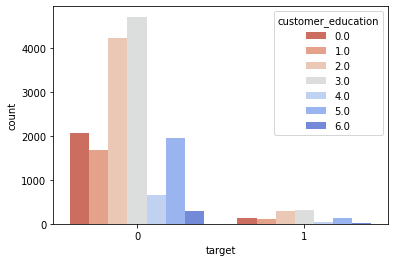

In [11]:
#sns.countplot(x='target',data=train1,hue='homebanking_active',palette="coolwarm_r")
#sns.countplot(x='target',data=train1,hue='has_homebanking',palette="coolwarm_r")
#sns.countplot(x='target',data=train1,hue='has_insurance_21',palette="coolwarm_r")
#sns.countplot(x='target',data=train1,hue='has_insurance_23',palette="coolwarm_r")
#sns.countplot(x='target',data=train1,hue='has_life_insurance_fixed_cap',palette="coolwarm_r")
#sns.countplot(x='target',data=train1,hue='has_life_insurance_decreasing_cap',palette="coolwarm_r")
#sns.countplot(x='target',data=train1,hue='has_fire_car_other_insurance',palette="coolwarm_r")
#sns.countplot(x='target',data=train1,hue='has_personal_loan',palette="coolwarm_r")
#sns.countplot(x='target',data=train1,hue='has_mortgage_loan',palette="coolwarm_r")
#sns.countplot(x='target',data=train1,hue='has_current_account',palette="coolwarm_r")
#sns.countplot(x='target',data=train1,hue='has_pension_saving',palette="coolwarm_r")
#sns.countplot(x='target',data=train1,hue='has_savings_account',palette="coolwarm_r")
sns.countplot(x='target',data=train1,hue='customer_education',palette="coolwarm_r")

ppl w/o home banking active tend to churn less. is there a diff between that and has_homebanking? 
insurance 21 or 23 -> if not then don't churn, noone who has it churned? 
fixed insurance cap, very low amount of ppl have it. 
decreasing cap seems interesting. 
fire car insurance interesting.
not many ppl w personal loan, same for mortgage. 
current account seems to have effect on churn 
no churn if pension savings.
gender does seems to have a low effect on churn. 
more chrun if occupation code =9
seems like having children might have an effect but have to reformat that var. 
ppl in couple seem to churn more.

In [10]:
cont_vars

['bal_insurance_21',
 'bal_insurance_23',
 'cap_life_insurance_fixed_cap',
 'cap_life_insurance_decreasing_cap',
 'prem_fire_car_other_insurance',
 'bal_personal_loan',
 'bal_mortgage_loan',
 'bal_current_account',
 'bal_pension_saving',
 'bal_savings_account',
 'bal_savings_account_starter',
 'bal_current_account_starter',
 'customer_since_all',
 'customer_since_bank',
 'customer_birth_date',
 'customer_postal_code']

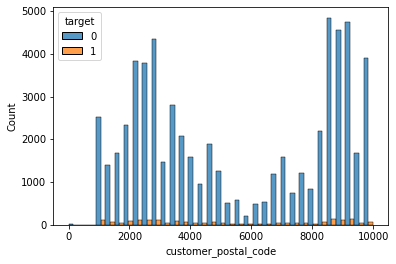

In [11]:
ax = sns.histplot(x = 'customer_postal_code', hue = 'target', data = train1, multiple='dodge')

balance insurance 21/23 <2000 churn more
ppl w balance curr account = 0 churn 
balance saving account interesting 
customer since all -> new customers tend to churn. same for bank and for age.
one outlier in birth_date
some areas/ pc seems to have higher churn rate. 

## data cleaning 
'bal_insurance_21',
 'bal_insurance_23',
 'cap_life_insurance_fixed_cap',
 'cap_life_insurance_decreasing_cap',
 'prem_fire_car_other_insurance',
 'bal_personal_loan',
 'bal_mortgage_loan',
 'bal_current_account',
 'bal_pension_saving',
 'bal_savings_account',
 'bal_savings_account_starter',
 'bal_current_account_starter', 
 and 
 has_insurance_21
has_insurance_23 
has_life_insurance_fixed_cap
has_life_insurance_decreasing_cap
has_fire_car_other_insurance 
has_personal_loan 
has_mortgage_loan 
has_current_account 
has_pension_saving 
has_savings_account 
has_savings_account_starter 
has_current_account_starter 
kinda convey the same information imo. 

For the date time data, one easy fix would be to compute the amount of time in years (up until now or from the lowest value in the df). that way we can get rid of this annoying data type that random forest do not like.  

For customer_children, we could replace all the different values and make it just yes or no. Problem is there is a lot of nans in the dataset when it comes to that but based on just visualisation having children or not seems to have effect on the client churning. 

Same goes for the nan values of couple/ single. How can we 'fix' them ? 

For customer education we are missing 73% of data. should we just drop the column?
Then we have nan's in the following features: 
customer_since_all           0.367364
customer_since_bank          0.390913
customer_occupation_code     3.143005

for the time we could just drop the rows as it is a very small amount of them that we are missing. 
for the occupation code i don't rly know as idk what those number represent. 

We also have to check for weird datapoint and outliers!!!
there is one guy that is born in in the 1800s for example.

## feature engineering 
- We could see if there is a significant (large) difference in say balance or savings as this could be an indicator that the client is about to churn. (can just be stored as a boolean). 
- can also compute a boolean regarding the change in some services that the client has. Say he dropped in insurrance 21 last month or smtg. also as a boolean 


## regarding modeling
the most used techniques are logistic regression, random forest, xgboost. People usually use random forest as a baseline reference and then they tune it or try other models to see if they can beat the random forest. 

## STEPS REQUIRED
## A-Identify Business Problems
- What is the likelihood of an active customer to leave the bank?
- What are the key indicators of a customer churn?
- What retention strategies can be implemented based on results to diminish prospective customer churn?




## B- Data Preprocessing
- Evaluate data structure
- Check target variable distribution
- Clean the dataset
- Deal with missing data
 

## C- Data Evaluation
- Plot Charts and Histograms
- Analyze the distribution of categorical variables
- Analyze the churn rate by variable
- Find correlations between variables
- Making a conclusion from the above findings
- Split the dataset in training and validation sets
- Split the dependent variable from the independent variables.
- Remove Identifier: Customer ID
- Normalize Variables

## D- Model Selection
Suggested models:
- Logistic Regression
- Random Forrest
- KNN
- SVM
-xgboost

## E- Model Evalation


## F- Model Improvement
Tuning Hyperparameters

## G- Model Deployement

## Resources